# Image Classification with Convolutional Neural Network (CNN)

***

## Contents
1. [Overview](#1)
2. [Importing required libraries](#2)
3. [Dataset](#3)
4. [Machine learning modelling](#4)<br>
    4.1 [Data preprocessing](#4.1)<br>
    4.2 [Model training](#4.2)<br>
    4.3 [Model evaluation](#4.3)<br>
    4.4 [Examples](#4.4)<br>
5. [Conclusion](#5)

***

<a id = '1'></a>
## 1. *Overview*
This notebook shows how a CNN can learn to recognise the presence of certain features in different images (gender in this case). Potentially, image recognition can be applied to solve many different problems, such as object detection, face detection, security surveillance, among many others.

***

<a id = '2'></a>
## 2. *Importing required libraries*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score

from keras import optimizers
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
%matplotlib inline

***
<a id = '3'></a>
## 3. *Dataset exploration*
For this project we will use <a href = "https://www.kaggle.com/jessicali9530/celeba-dataset" target="_blank">CelebFaces Attributes (CelebA)</a> dataset found on Kaggle

<blockquote>Context

A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).
Content

Overall

    202,599 number of face images of various celebrities
    10,177 unique identities, but names of identities are not given
    40 binary attribute annotations per image
    5 landmark locations

Data Files

    imgalignceleba.zip: All the face images, cropped and aligned
    listevalpartition.csv: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
    listbboxceleba.csv: Bounding box information for each image. "x1" and "y1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
    listlandmarksalign_celeba.csv: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
    listattrceleba.csv: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

Acknowledgements

Original data and banner image source came from http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
As mentioned on the website, the CelebA dataset is available for non-commercial research purposes only. For specifics please refer to the website.

The creators of this dataset wrote the following paper employing CelebA for face detection:

S. Yang, P. Luo, C. C. Loy, and X. Tang, "From Facial Parts Responses to Face Detection: A Deep Learning Approach", in IEEE International Conference on Computer Vision (ICCV), 2015</blockquote>

#### Format of dataset
The dataset contains 202,599 images all within a single folder, with accompanying csv files containing labels for their attributes (facial features, gender, etc.) and partition (train, validation, test). In the interest of time, a random subsample of the full dataset will be used for this notebook. The [accompanying .py file]() is the script used to separate the sampled images into their respective train/validation/test folders.

Images within the dataset are all of resolution 178x218. An example image is shown below.

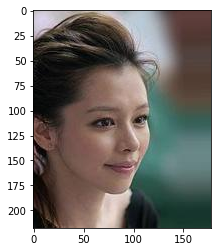

In [2]:
# Folder containing dataset
main_folder = 'E:\\datascience\\celebA\\'
train_folder = main_folder + 'training\\'
validation_folder = main_folder + 'validation\\'
test_folder = main_folder + 'test\\'

# Example image
EXAMPLE_PIC = test_folder + 'test_Male\\197126.jpg'
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)

In [3]:
# Load attributes of images
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.replace(to_replace = -1, value = 0, inplace = True)

# Print all available attributes in dataset
print("List of Features: ")
for i, j in enumerate(df_attr.columns):
    print(i, j)

print('#'*20)

# Print selected attribute of the example image above
print(df_attr.loc[df_attr['image_id'] == EXAMPLE_PIC.split('\\')[-1]][['Male']])

List of Features: 
0 image_id
1 5_o_Clock_Shadow
2 Arched_Eyebrows
3 Attractive
4 Bags_Under_Eyes
5 Bald
6 Bangs
7 Big_Lips
8 Big_Nose
9 Black_Hair
10 Blond_Hair
11 Blurry
12 Brown_Hair
13 Bushy_Eyebrows
14 Chubby
15 Double_Chin
16 Eyeglasses
17 Goatee
18 Gray_Hair
19 Heavy_Makeup
20 High_Cheekbones
21 Male
22 Mouth_Slightly_Open
23 Mustache
24 Narrow_Eyes
25 No_Beard
26 Oval_Face
27 Pale_Skin
28 Pointy_Nose
29 Receding_Hairline
30 Rosy_Cheeks
31 Sideburns
32 Smiling
33 Straight_Hair
34 Wavy_Hair
35 Wearing_Earrings
36 Wearing_Hat
37 Wearing_Lipstick
38 Wearing_Necklace
39 Wearing_Necktie
40 Young
####################
        Male
197125     0


Above we see a list of the labeled features available for each image of the dataset, and the "Male" class we will be modelling for. The example image above is labeled '0' for "Male" meaning that it is not a male photographed.

#### Distribution of Dataset
CNNs have been shown to perform best when the predicted classes are balanced. In this dataset we can observe that the chosen attributes/classes are imbalanced, suggesting that we will need to balance the classes when modelling. Previously when subsampling the dataset class imbalance was already considered and stratified sampling was conducted.

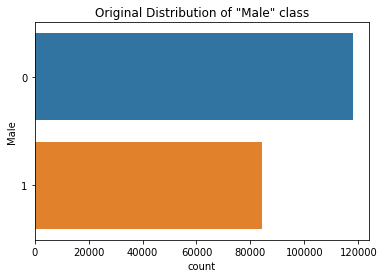

Number of Female: 118165
Number of Male: 84434


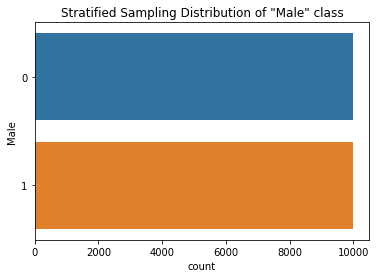

Number of Female: 10000
Number of Male: 10000


In [4]:
# Plot Male vs Female
plt.title('Original Distribution of "Male" class')
sns.countplot(y= 'Male', data = df_attr)
plt.show() # More female than male in dataset
print('Number of Female:',len(df_attr[df_attr['Male'] == 0]))
print('Number of Male:',len(df_attr[df_attr['Male'] == 1]))

# Snippet of code from accompanying .py file
training_id = pd.concat([df_attr.loc[(df_attr.Male == 0)].sample(20000//2),
                        df_attr.loc[(df_attr.Male == 1)].sample(20000//2)])

# Plot training dataset Male vs Female
plt.title('Stratified Sampling Distribution of "Male" class')
sns.countplot(y= 'Male', data = training_id)
plt.show() # More female than male in dataset
print('Number of Female:',len(training_id[training_id['Male'] == 0]))
print('Number of Male:',len(training_id[training_id['Male'] == 1]))

***

<a id = '4'></a>
<a id = '4.1'></a>
## 4. *Machine learning modelling*
### 4.1 *Data preprocessing*
#### Splitting the dataset into training, validation and test sets
As quoted from the description of the dataset, recommended partitioning of dataset
<blockquote>listevalpartition.csv: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing</blockquote>
Taking training time into consideration however, the number of images used will be reduced to 20000, 5000, 5000 for training, validation, and test sets respectively.

In [5]:
# Initialise variables
EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

WIDTH = 178
HEIGHT = 218
TARGET_SIZE = (HEIGHT, WIDTH)

#### Data augmentation
This step generates additional images with modifications made to the images available in the dataset, allowing the model to learn from this new images to better predict for never seen images when the model is deployed. Shown below is an example of what data augmentation will do to existing images within the dataset.

Image shape:  (1, 218, 178, 3)


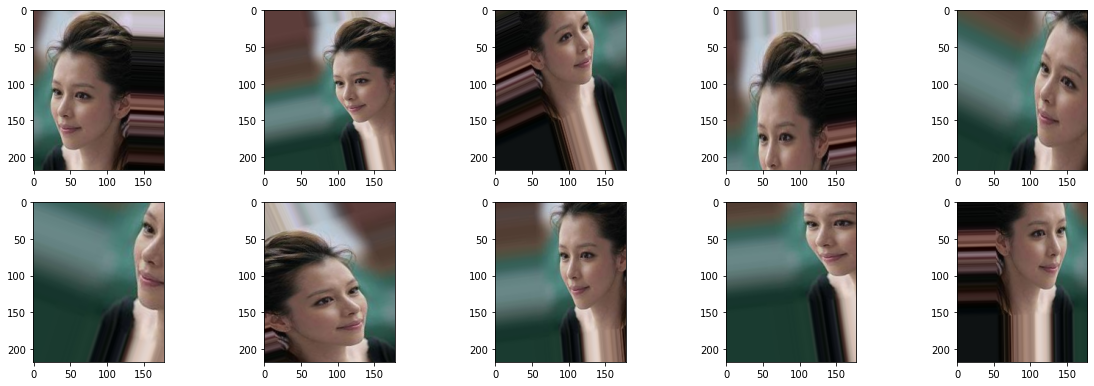

In [6]:
# Reshape example image for keras
img = img_to_array(img)
img = img.reshape(1, HEIGHT, WIDTH, 3)
print("Image shape: ", img.shape)

# Image generator for data augmentation of training set
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   width_shift_range = 0.4,
                                   height_shift_range = 0.4,
                                   zoom_range = 0.3,
                                   rotation_range = 20,
                                   rescale = 1./255.
                                   )

# Plotting augmented images of the example image
plt.figure(figsize = (20,10))
plt.title('Data Augmentation', fontsize = 28)

i = 0
for batch in train_datagen.flow(img, batch_size = 1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    else:
        i += 1
plt.show()

In [7]:
# Data generator for validation and test sets (No augmentation other than scaling RGB values between 0 and 1)
test_gen = ImageDataGenerator(rescale = 1./255.)

In [8]:
# Training set data generator for model fitting
train_generator = train_datagen.flow_from_directory(train_folder,
                                 target_size = TARGET_SIZE,
                                 batch_size = BATCH_SIZE,
                                 class_mode = 'binary'
                                 )

Found 20000 images belonging to 2 classes.


In [9]:
# Validation set data generator 
valid_generator = test_gen.flow_from_directory(validation_folder,
                                 target_size = TARGET_SIZE,
                                 batch_size = BATCH_SIZE,
                                 class_mode = 'binary'
                                 )

Found 5000 images belonging to 2 classes.


In [10]:
# Test set data generator
test_generator = test_gen.flow_from_directory(test_folder,
                                 target_size = TARGET_SIZE,
                                 batch_size = BATCH_SIZE,
                                 class_mode = 'binary',
                                 shuffle = False
                                 )

Found 5000 images belonging to 1 classes.


In [11]:
# Check class labels
print("Train: \n",train_generator.class_indices)
print("Validation: \n",valid_generator.class_indices)
print("Test: \n",test_generator.class_indices)

Train: 
 {'Male': 0, 'NotMale': 1}
Validation: 
 {'Male': 0, 'NotMale': 1}
Test: 
 {'test_Male': 0}


Now we have our data generators for all three partitions, and have confirmed that the generators recognised the two classes for the training and validation set, while test set class is unknown.

<a id = '4.2'></a>
### 4.2 *Model Training*
#### Building the model
In this project InceptionV3 is a pre-trained model selected for transfer learning. The top layers are removed and replaced by new layers that classifies the desired labels. The pre-trained model has been trained on the ImageNet dataset, learning to distinguish features such as textures, edges, contrasts, among others in the lower layers. Hence, retraining of the lower layers are not required

In [12]:
# InceptionV3 model
model = Sequential()
model.add(InceptionV3(include_top = False, pooling = 'avg', weights = 'imagenet'))

# Add custom top layers that will be trained
model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(2048, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation = 'sigmoid'))

# InceptionV3 layers will not be trained
model.layers[0].trainable = False

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_95 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2

In [14]:
# Compile the model
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#### Training the model
The model will be trained to identify "Male" attributes in images. A check pointer will be used to save the best performing models during the training process.

Epoch 1/50
156/156 [==============================] - 449s 3s/step - loss: 0.3897 - accuracy: 0.8575 - val_loss: 0.1958 - val_accuracy: 0.9235
Epoch 2/50
156/156 [==============================] - 151s 966ms/step - loss: 0.2856 - accuracy: 0.8814 - val_loss: 0.1815 - val_accuracy: 0.9273
Epoch 3/50
156/156 [==============================] - 151s 967ms/step - loss: 0.2677 - accuracy: 0.8856 - val_loss: 0.1932 - val_accuracy: 0.9273
Epoch 4/50
156/156 [==============================] - 151s 966ms/step - loss: 0.2658 - accuracy: 0.8884 - val_loss: 0.1796 - val_accuracy: 0.9313
Epoch 5/50
156/156 [==============================] - 150s 964ms/step - loss: 0.2586 - accuracy: 0.8912 - val_loss: 0.1735 - val_accuracy: 0.9345
Epoch 6/50
156/156 [==============================] - 149s 956ms/step - loss: 0.2536 - accuracy: 0.8927 - val_loss: 0.1659 - val_accuracy: 0.9373
Epoch 7/50
156/156 [==============================] - 150s 958ms/step - loss: 0.2546 - accuracy: 0.8919 - val_loss: 0.1667 - va

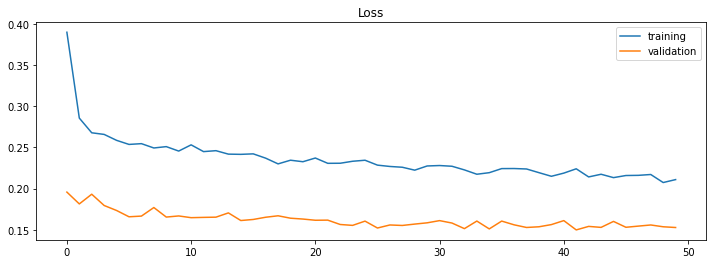

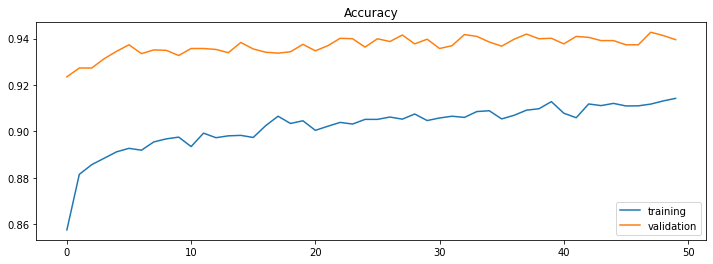

In [15]:
# Training the model
checkpointer_male = ModelCheckpoint(filepath = 'saved_models\\weights.best.inc.male.hdf5')

hist_male = model.fit(train_generator,
                     steps_per_epoch = len(train_generator.filenames)//BATCH_SIZE,
                     epochs = EPOCHS,
                     validation_data = valid_generator,
                     validation_steps = len(valid_generator.filenames)//BATCH_SIZE,
                     callbacks = [checkpointer_male]
                     )

# Plot loss function value through epochs
plt.figure(figsize=(12, 4))
plt.plot(hist_male.history['loss'], label = 'training')
plt.plot(hist_male.history['val_loss'], label = 'validation')
plt.legend()
plt.title('Loss')
plt.show()


# Plot accuracy through epochs
plt.figure(figsize=(12, 4))
plt.plot(hist_male.history['accuracy'], label = 'training')
plt.plot(hist_male.history['val_accuracy'], label = 'validation')
plt.legend()
plt.title('Accuracy')
plt.show()

In additional to the model trained on top of InceptionV3, we shall train another CNN without the use of transfer learning

In [16]:
# CNN without InceptionV3
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(218, 178, 3)))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(1, activation='sigmoid'))

In [17]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 216, 176, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 108, 88, 32)       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 106, 86, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 43, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 43, 64)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 51, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 20, 128)      

In [18]:
# Compile the model
model2.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Epoch 1/50
156/156 [==============================] - 148s 928ms/step - loss: 0.6660 - accuracy: 0.6121 - val_loss: 0.5486 - val_accuracy: 0.7220
Epoch 2/50
156/156 [==============================] - 145s 928ms/step - loss: 0.5995 - accuracy: 0.6756 - val_loss: 0.4902 - val_accuracy: 0.7810
Epoch 3/50
156/156 [==============================] - 145s 928ms/step - loss: 0.5710 - accuracy: 0.7023 - val_loss: 0.4241 - val_accuracy: 0.8079
Epoch 4/50
156/156 [==============================] - 145s 929ms/step - loss: 0.5546 - accuracy: 0.7159 - val_loss: 0.4415 - val_accuracy: 0.8115
Epoch 5/50
156/156 [==============================] - 145s 929ms/step - loss: 0.5361 - accuracy: 0.7310 - val_loss: 0.4484 - val_accuracy: 0.7929
Epoch 6/50
156/156 [==============================] - 145s 930ms/step - loss: 0.5159 - accuracy: 0.7449 - val_loss: 0.3847 - val_accuracy: 0.8217
Epoch 7/50
156/156 [==============================] - 145s 931ms/step - loss: 0.5020 - accuracy: 0.7548 - val_loss: 0.3719 -

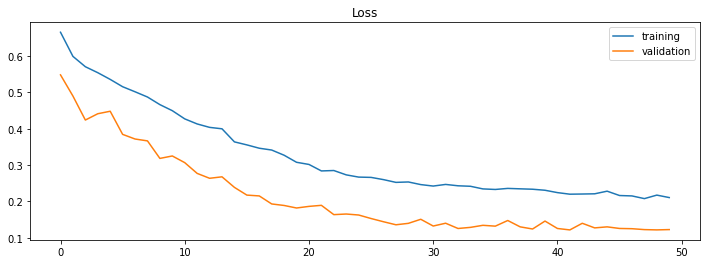

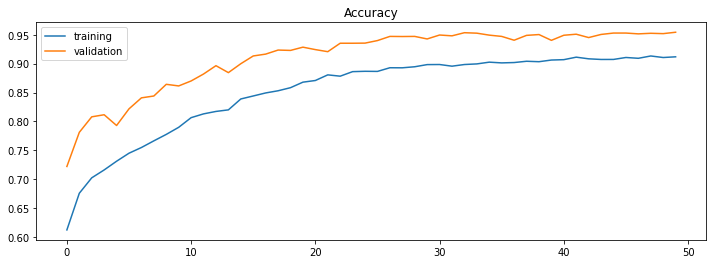

In [19]:
# Training the model
checkpointer_male2 = ModelCheckpoint(filepath = 'saved_models\\weights.best.cnn.male.hdf5')

hist_male2 = model2.fit(train_generator,
                     steps_per_epoch = len(train_generator.filenames)//BATCH_SIZE,
                     epochs = EPOCHS,
                     validation_data = valid_generator,
                     validation_steps = len(valid_generator.filenames)//BATCH_SIZE,
                     callbacks = [checkpointer_male2]
                     )

# Plot loss function value through epochs
plt.figure(figsize=(12, 4))
plt.plot(hist_male2.history['loss'], label = 'training')
plt.plot(hist_male2.history['val_loss'], label = 'validation')
plt.legend()
plt.title('Loss')
plt.show()


# Plot accuracy through epochs
plt.figure(figsize=(12, 4))
plt.plot(hist_male2.history['accuracy'], label = 'training')
plt.plot(hist_male2.history['val_accuracy'], label = 'validation')
plt.legend()
plt.title('Accuracy')
plt.show()

<a id = '4.3'></a>
### 4.3 Model Evaluation
Now that the models are trained, we will evaluate them by predicting the classes in the test set.

#### InceptionV3 model

In [20]:
# Make predictions on test set
pred = model.predict(test_generator,
                      steps = len(test_generator),
                      verbose = 1)

filenames = test_generator.filenames

results = pd.DataFrame(data = {'image_id':filenames, 'prob':pred[:,0]})
results.image_id = results.image_id.str.split('\\').str[1]
results.head()

40/40 [==============================] - 33s 826ms/step


,image_id,prob
0,182641.jpg,0.998044
1,182653.jpg,0.194666
2,182657.jpg,0.997294
3,182662.jpg,0.014657
4,182663.jpg,0.937032


In [21]:
# Create dataframe containing the test set, predictions, and actual class
results['class'] = results['prob']
results['class'] = results['class'].apply(lambda x: 1 if x <= 0.5 else 0)
results = pd.merge(results, df_attr[['image_id', 'Male']], how = 'left', on = 'image_id')

print(len(results))
print(results.head())

5000
     image_id      prob  class  Male
0  182641.jpg  0.998044      0     0
1  182653.jpg  0.194666      1     1
2  182657.jpg  0.997294      0     0
3  182662.jpg  0.014657      1     1
4  182663.jpg  0.937032      0     0


In [22]:
print("Model accuracy score: ", accuracy_score(results['Male'], results['class']))
print("Model f1 score: ", f1_score(results['Male'], results['class']))

Model accuracy score:  0.9244
Model f1 score:  0.9249404289118347


The model has managed to achieve over 92% classification accuracy when classifying where an image is "Male" or not. 

#### CNN without using InceptionV3

In [23]:
# Make predictions on test set
pred2 = model2.predict(test_generator,
                      steps = len(test_generator),
                      verbose = 1)

filenames = test_generator.filenames

results2 = pd.DataFrame(data = {'image_id':filenames, 'prob':pred2[:,0]})
results2.image_id = results2.image_id.str.split('\\').str[1]
results2.head()

40/40 [==============================] - 4s 103ms/step


,image_id,prob
0,182641.jpg,0.999999
1,182653.jpg,0.092155
2,182657.jpg,0.893312
3,182662.jpg,0.085085
4,182663.jpg,0.999456


In [24]:
# Create dataframe containing the test set, predictions, and actual class
results2['class'] = results2['prob']
results2['class'] = results2['class'].apply(lambda x: 1 if x <= 0.5 else 0)
results2 = pd.merge(results2, df_attr[['image_id', 'Male']], how = 'left', on = 'image_id')

print(len(results2))
print(results2.head())

5000
     image_id      prob  class  Male
0  182641.jpg  0.999999      0     0
1  182653.jpg  0.092155      1     1
2  182657.jpg  0.893312      0     0
3  182662.jpg  0.085085      1     1
4  182663.jpg  0.999456      0     0


In [25]:
print("Model accuracy score: ", accuracy_score(results2['Male'], results2['class']))
print("Model f1 score: ", f1_score(results2['Male'], results2['class']))

Model accuracy score:  0.9418
Model f1 score:  0.9410334346504559


In comparison, the traditional CNN managed to obtain an accuracy score of over 94% which is higher than the InceptionV3 model. As both models took a similar length of time to train, the traditional CNN is the better performance in this case. 

Something that can be done differently for the InceptionV3 model would be to train the top layers of the InceptionV3 model in addition to our custom layers, instead of training only the custom layers. This approach may lead to a better performing model.


<a id='4.4'></a>
### 4.4 *Examples*
Finally, we shall look at some of the predictions from the InceptionV3 model and see examples of correct and incorrect predictions.

In [26]:
# Function to plot image and get correct probability and class
def get_classes(row, j):
    prob = row['prob']*100
    
    
    EXAMPLE_PIC = test_folder + 'test_Male\\' + str(row['image_id'])
    img = load_img(EXAMPLE_PIC)
    ax[j].grid(False)
    ax[j].imshow(img)
    
    
    if prob <= 50:
        ax[j].set_title("Male, Prob: " + "{:.2f}".format(100 - prob) + "%")
        
    else:
        ax[j].set_title('Female, Prob: ' + "{:.2f}".format(prob) + "%")
        

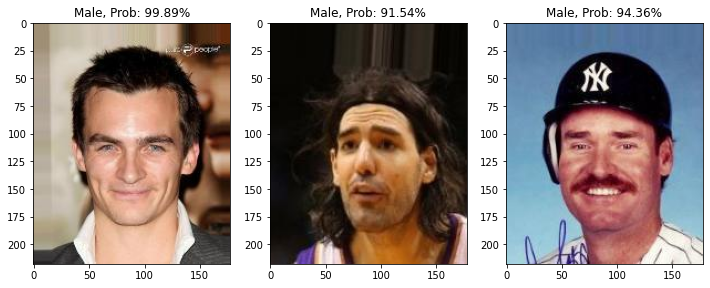

In [27]:
# Correct predictions
df_correct = results.loc[results.Male == results['class']]
correct = df_correct.sample(3, random_state = 3)

# Plot correct predictions
fig, ax = plt.subplots(1,3, figsize = (12,6))
j = 0
for i, row in correct.iterrows():
    get_classes(row, j)
    j += 1

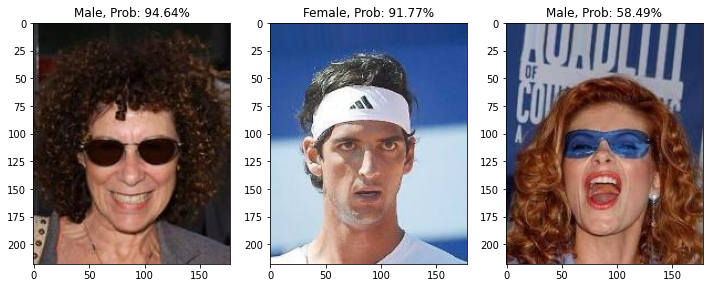

In [32]:
# Incorrect predictions
df_incorrect = results.loc[results.Male != results['class']]
incorrect = df_incorrect.sample(3, random_state = 3)

# Plot incorrect predictions
fig, ax = plt.subplots(1,3, figsize = (12,6))
j = 0
for i, row in incorrect.iterrows():
    get_classes(row, j)
    j += 1

From the incorrect predictions we observe that the model is confidently wrong in some cases, and the images may suggest that someone wearing large accessories on their faces while having no obvious "Male" feature like a moustache may end up confusing the model.

***
<a id='5'></a>
## 5. Conclusion
In this notebook we have created both a traditional CNN and a CNN built on InceptionV3 to classify images from the CelebA dataset by their gender, achieving a good accuracy score of over 90% in both models.